# Summary

# Imports

In [ ]:
import concurrent.futures
import itertools
import importlib
import multiprocessing
import os
import os.path as op
import pickle
import subprocess
import sys
import tempfile
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sqlalchemy as sa
from scipy import stats
from sklearn import metrics

from kmtools import py_tools, sequence_tools

In [ ]:
%matplotlib inline

In [ ]:
pd.set_option("max_columns", 100)

In [ ]:
SRC_PATH = Path.cwd().joinpath('..', 'src').resolve(strict=True)

if SRC_PATH.as_posix() not in sys.path:
    sys.path.insert(0, SRC_PATH.as_posix())

import helper
importlib.reload(helper)

# Parameters

In [ ]:
NOTEBOOK_PATH = Path('validation_remote_homology_detection')
NOTEBOOK_PATH

In [ ]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

In [ ]:
proc = subprocess.run(["git", "rev-parse", "--short", "HEAD"], stdout=subprocess.PIPE)
GIT_REV = proc.stdout.decode().strip()
GIT_REV

In [ ]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("NETWORK_NAME", GIT_REV)

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT

In [ ]:
DEBUG = "CI" not in os.environ    
DEBUG

In [ ]:
if DEBUG:
    NETWORK_NAME = "dcn_old_0,9c5a963"
else:
    assert NETWORK_NAME is not None

In [ ]:
# if DEBUG:
#     %load_ext autoreload
#     %autoreload 2

# `DATAPKG`

In [ ]:
DATAPKG = {}

In [ ]:
DATAPKG['uniparc-domain-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("uniparc-domain-wstructure", "master")
)

In [ ]:
DATAPKG['adjacency_net_v2'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("adjacency-net-v2", "master")
)

In [ ]:
DATAPKG['hhsuite-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("hhsuite-wstructure", "master")
)

# Load data

## Remote homology detection

In [ ]:
remote_homology_dataset_file = (
    DATAPKG['hhsuite-wstructure']
    .joinpath('scop_remote_homology_detection', 'remote_homology_dataset.parquet')
)

In [ ]:
remote_homology_dataset = pq.read_table(remote_homology_dataset_file).to_pandas()

In [ ]:
display(remote_homology_dataset.head(2))
print(len(remote_homology_dataset))

In [ ]:
remote_homology_dataset['adjacency_coverage_1'] = (
    remote_homology_dataset['adjacency_idx_1'].apply(lambda l: len(set(l))) /
    remote_homology_dataset['sequence'].str.len()
)


remote_homology_dataset['adjacency_coverage_2'] = (
    remote_homology_dataset['adjacency_idx_2'].apply(lambda l: len(set(l))) /
    remote_homology_dataset['sequence'].str.len()
)

In [ ]:
def validate_adjacency_df(adjacency_df):
    assert (adjacency_df['adjacency_idx_1'].apply(min) >= 0).all()
    assert (adjacency_df['adjacency_idx_2'].apply(min) >= 0).all()
    
    assert (
        adjacency_df['adjacency_idx_1'].apply(max) <
        adjacency_df['sequence'].str.len()
    ).all()

    assert (
        adjacency_df['adjacency_idx_2'].apply(max) <
        adjacency_df['sequence'].str.len()
    ).all()

    
validate_adjacency_df(remote_homology_dataset)

# Run network

In [ ]:
%run trained_networks.ipynb

## Make predictions

In [ ]:
for network_name in NETWORK_NAME.split(','):
    remote_homology_dataset[network_name] = (
        helper.predict_with_network(
            remote_homology_dataset.copy(),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )

In [ ]:
assert not remote_homology_dataset[NETWORK_NAME.split(',')].isnull().any().any()

## Save to cache

In [35]:
table = pa.Table.from_pandas(remote_homology_dataset, preserve_index=True)
pq.write_table(
    table,
    OUTPUT_PATH.joinpath(f"{NETWORK_NAME}_dataset.parquet"),
    version='2.0',
    flavor='spark',
)

# Analysis

### `remote_homology_dataset_filtered`

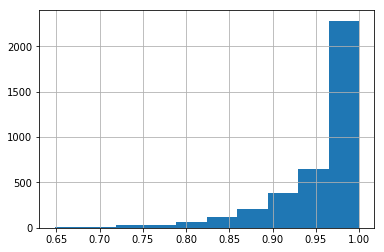

In [36]:
remote_homology_dataset['adjacency_coverage_1'].hist()

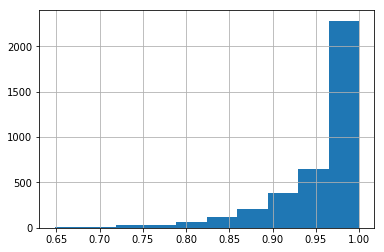

In [37]:
remote_homology_dataset['adjacency_coverage_2'].hist()

In [38]:
query_ids_w3plus = {
    query_id
    for query_id, group in 
        remote_homology_dataset
        .groupby('query_id')
    if len(group) >= 3
}

remote_homology_dataset_filtered = (
    remote_homology_dataset[
        remote_homology_dataset['query_id'].isin(query_ids_w3plus)
    ]
    .copy()
)

print(len(remote_homology_dataset))
print(len(remote_homology_dataset_filtered))

3768
2665


### Prepare data for plots

In [39]:
features = (
    [
        "identity_calc",
        "coverage_calc", 
        "identity", "similarity",
        "score",  "probability", # "evalue",
        "sum_probs",
    ] + NETWORK_NAME.split(',')
)

In [40]:
for scop_level in [1, 2, 3, 4]:
    remote_homology_dataset_filtered[f'scop_domain_matches_l{scop_level}'] = (
        remote_homology_dataset_filtered.apply(
            lambda row: 
                '.'.join(row['scop_domain'].split('.')[:scop_level]) == 
                '.'.join(row['scop_domain_canonical'].split('.')[:scop_level]),
            axis=1,
        )
    )

#### `DATA_ALL`

In [41]:
DATA_ALL = {}
for scop_level in [1, 2, 3, 4]:
    df = remote_homology_dataset_filtered.copy()
    data = []
    for feature in features:
        corr, pvalue = stats.spearmanr(df[feature], df[f'scop_domain_matches_l{scop_level}'])
        auc = metrics.roc_auc_score(df[f'scop_domain_matches_l{scop_level}'], df[feature])
        data.append((feature, corr, pvalue, auc))
    out_df = pd.DataFrame(data, columns=['feature', 'correlation', 'pvalue', 'auc'])
    DATA_ALL[scop_level] = len(df['query_id'].drop_duplicates()), len(df), out_df

#### `DATA_GBQ`

In [42]:
DATA_GBQ = {}

num_skips_small = {1: 0, 2: 0, 3: 0, 4: 0}
num_skips_eq = {1: 0, 2: 0, 3: 0, 4: 0}
num_skips_neq = {1: 0, 2: 0, 3: 0, 4: 0}

for scop_level in [1, 2, 3, 4]:
    df = remote_homology_dataset_filtered.copy()
    data = {f: {'corrs': [], 'pvalues': [], 'aucs': []} for f in features}
    count_groups = 0
    count_rows = 0
    for query_id, group in df.groupby('query_id'):
        if len(group) < 3:
            num_skips_small[scop_level] += 1
            continue
        elif (group[f'scop_domain_matches_l{scop_level}'] == True).all():
            num_skips_eq[scop_level] += 1
            continue
        elif (group[f'scop_domain_matches_l{scop_level}'] == False).all():
            num_skips_neq[scop_level] += 1
            continue
        for feature in features:
            if len(group[feature].drop_duplicates()) == 1:
                print(f"Skipping '{feature}'")
                continue
            corr, pvalue = stats.spearmanr(group[feature], group[f'scop_domain_matches_l{scop_level}'])
            auc = metrics.roc_auc_score(group[f'scop_domain_matches_l{scop_level}'], group[feature])
            data[feature]['corrs'].append(corr)
            data[feature]['pvalues'].append(pvalue)
            data[feature]['aucs'].append(auc)
        count_groups += 1
        count_rows += len(group)
    data_list = [
        (k, np.mean(v['corrs']), np.mean(v['pvalues']), np.mean(v['aucs']))
        for k, v in data.items()
    ]
    out_df = pd.DataFrame(data_list, columns=['feature', 'correlation', 'pvalue', 'auc'])
    DATA_GBQ[scop_level] = count_groups, count_rows, out_df
    
print(num_skips_small)
print(num_skips_eq)
print(num_skips_neq)

Skipping 'identity'
{1: 0, 2: 0, 3: 0, 4: 0}
{1: 206, 2: 65, 3: 52, 4: 8}
{1: 50, 2: 265, 3: 306, 4: 386}


### Plot

In [43]:
cmap = plt.cm.get_cmap('Set1', 10)

In [44]:
scop_levels = {
    1: "class",
    2: "fold",
    3: "superfamily",
    4: "family",
}

In [45]:
feature_names = {
    'identity_calc': 'identity (aln.)',
    'coverage_calc': 'coverage (aln.)',
}

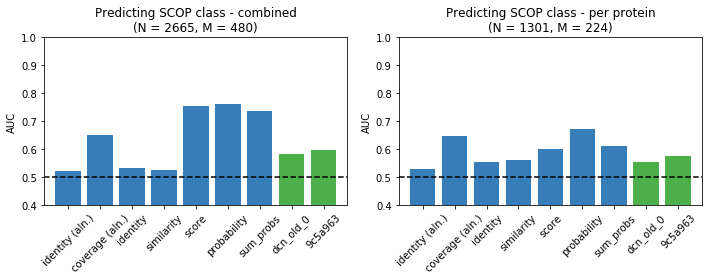

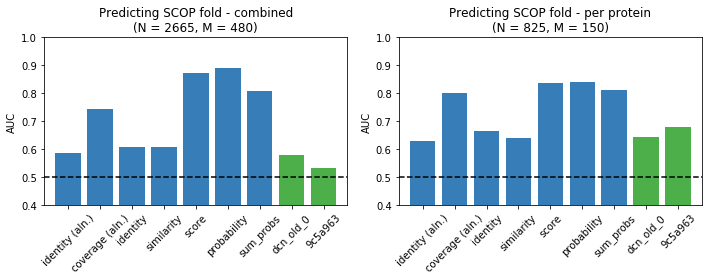

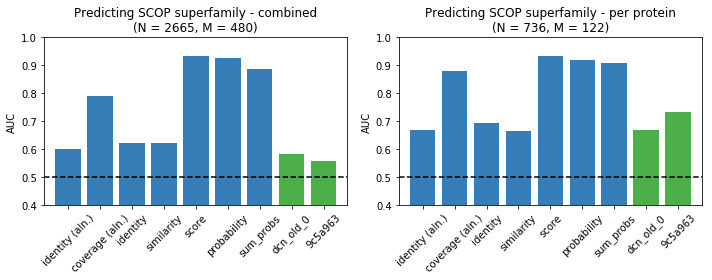

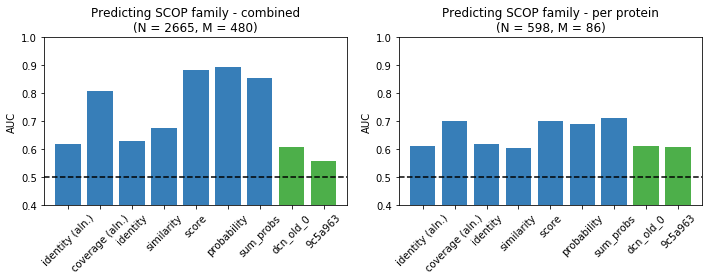

In [46]:
for scop_level in DATA_ALL:
    fg, axs = plt.subplots(1, 2, figsize=(10, 4))

    plt.sca(axs[0])
    num1, num2, df = DATA_ALL[scop_level]
    x = np.arange(len(df))
    c = [cmap(2) if f in NETWORK_NAME.split(',') else cmap(1) for f in df['feature']]
#     c = cmap(1)
    plt.bar(x, df['auc'].abs(), color=c)
    plt.xticks(x, [feature_names.get(f, f) for f in df['feature'].values], rotation=45)
    plt.ylim(0.4, 1)
    plt.ylabel("AUC")
    plt.title(
        f"Predicting SCOP {scop_levels[scop_level]} - combined\n"
        f"(N = {num2}, M = {num1})")
    plt.hlines(0.5, -0.75, len(features) - 0.25, linestyle='--')
    plt.ylim(0.4, 1)
    plt.xlim(-0.75, len(features) - 0.25)

    plt.sca(axs[1])
    num1, num2, df = DATA_GBQ[scop_level]
    x = np.arange(len(df))
    c = [cmap(2) if f in NETWORK_NAME.split(',') else cmap(1) for f in df['feature']]
#     c = cmap(1)
    plt.bar(x, df['auc'].abs(), color=c)
    plt.xticks(x, [feature_names.get(f, f) for f in df['feature'].values], rotation=45)
    plt.ylabel("AUC")
    plt.title(
        f"Predicting SCOP {scop_levels[scop_level]} - per protein\n"
        f"(N = {num2}, M = {num1})")
    plt.hlines(0.5, -0.75, len(features) - 0.25, linestyle='--')
    plt.ylim(0.4, 1)
    plt.xlim(-0.75, len(features) - 0.25)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PATH.joinpath(f"{NETWORK_NAME}_sl{scop_level}.png"), dpi=300, bbox_inches="tight")
    plt.savefig(OUTPUT_PATH.joinpath(f"{NETWORK_NAME}_sl{scop_level}.pdf"), bbox_inches="tight")